In [118]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

In [119]:
def get_options_at(stock: yf.Ticker, at: str) -> pd.DataFrame:
    """
    at: something like 20230723
    """
    # Fetch option chain
    front_option_chain = stock.option_chain(at)
    calls = front_option_chain.calls
    calls["cp"] = "c"
    puts = front_option_chain.puts
    puts["cp"] = "p"
    options = pd.concat([calls, puts], axis=0)
    return options

In [120]:
from scipy.stats import norm


def black_scholes(
    stock_price, strike, interest_rate, days_to_expiry, implied_volatility, option_type
):
    T = days_to_expiry / 365
    d1 = (
        np.log(stock_price / strike)
        + (interest_rate + 0.5 * implied_volatility**2) * T
    ) / (implied_volatility * np.sqrt(T))
    d2 = d1 - implied_volatility * np.sqrt(T)

    if option_type == "call":
        return stock_price * norm.cdf(d1) - strike * np.exp(
            -interest_rate * T
        ) * norm.cdf(d2)
    elif option_type == "put":
        return strike * np.exp(-interest_rate * T) * norm.cdf(
            -d2
        ) - stock_price * norm.cdf(-d1)


def calculate_greeks(
    stock_price, strike, interest_rate, days_to_expiry, implied_volatility, option_type
):
    T = days_to_expiry / 365
    d1 = (
        np.log(stock_price / strike)
        + (interest_rate + 0.5 * implied_volatility**2) * T
    ) / (implied_volatility * np.sqrt(T))
    d2 = d1 - implied_volatility * np.sqrt(T)

    delta, gamma, theta, vega = None, None, None, None

    if option_type == "call":
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (stock_price * implied_volatility * np.sqrt(T))
        theta = (
            -stock_price * norm.pdf(d1) * implied_volatility / (2 * np.sqrt(T))
            - interest_rate * strike * np.exp(-interest_rate * T) * norm.cdf(d2)
        ) / 365
        vega = stock_price * np.sqrt(T) * norm.pdf(d1) / 100
    elif option_type == "put":
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (stock_price * implied_volatility * np.sqrt(T))
        theta = (
            -stock_price * norm.pdf(d1) * implied_volatility / (2 * np.sqrt(T))
            + interest_rate * strike * np.exp(-interest_rate * T) * norm.cdf(-d2)
        ) / 365
        vega = stock_price * np.sqrt(T) * norm.pdf(d1) / 100

    return delta, gamma, theta, vega


In [121]:
def calculate_greeks_and_payoff(option, stock_price, interest_rate, days_to_expiry):
    call_flag = option["contractSymbol"].find("C") >= 0
    option_type = "call" if call_flag else "put"

    delta, gamma, theta, vega = calculate_greeks(
        stock_price,
        option["strike"],
        interest_rate,
        days_to_expiry,
        option["impliedVolatility"],
        option_type,
    )

    payoff = option["lastPrice"] * delta

    return pd.Series(
        {
            "symbol": option["contractSymbol"],
            "strike": option["strike"],
            "payoff": payoff,
            "delta": delta,
            "gamma": gamma,
            "vol": option['impliedVolatility'],
            "theta": theta,
            "vega": vega,
            "ask": option["ask"],
            "bid": option["bid"],
            "last": option["lastPrice"],
        }
    )


In [140]:
def plot_calendar_spread_expected_payoff(front_greeks: pd.DataFrame, back_greeks: pd.DataFrame, refPrice: float):
    calendar_spreads = front_greeks.copy()[['last', 'strike', 'vol', 'payoff']].rename(columns={"payoff": "front_payoff", })
    calendar_spreads.index = calendar_spreads.index.str.replace('0428', '0505')
    calendar_spreads['spread_price'] = - calendar_spreads['last'] + back_greeks['last']
    calendar_spreads['payoff'] = - calendar_spreads['front_payoff'] + back_greeks['payoff']
    lower, upper = (refPrice * 0.9, refPrice * 1.1)
    plt.axvline(refPrice, color='red')
    df = calendar_spreads[calendar_spreads.index.str.contains("C")]
    df = df.dropna().set_index("strike")
    df['EV'] = df['payoff'] - df['spread_price']
    df = df[df.index < upper]
    df = df[df.index > lower]
    df = df.sort_index()
    df['EV'].rename("call").plot()
    dfp = calendar_spreads[calendar_spreads.index.str.contains("P")]
    dfp = dfp.dropna().set_index("strike")
    dfp['EV'] = dfp['payoff'] - dfp['spread_price']
    dfp = dfp[dfp.index < upper]
    dfp = dfp[dfp.index > lower]
    dfp = dfp.sort_index()
    dfp['EV'].rename("put").plot()
    plt.legend()
    print(df.iloc[df['EV'].argmin()])
    c_predicted_price = float(df.iloc[df['EV'].argmin()].name)
    c_predicted_move = (c_predicted_price - refPrice) / refPrice
    print(f"call predicted price: {c_predicted_price}; predicted move: {100 * round(c_predicted_move, 2)}%")
    p_predicted_price = float(df.iloc[df['EV'].argmin()].name)
    p_predicted_move = (c_predicted_price - refPrice) / refPrice
    print(f"put predicted price: {p_predicted_price}; predicted move: {100 * round(p_predicted_move, 2)}%")

In [136]:
def plot(ticker: str):
    stock = yf.Ticker(ticker)
    expirations = stock.options
    today = datetime.now()
    days_to_expiry1 = max((datetime.fromisoformat(expirations[0]) - today).days, 1)
    days_to_expiry2 = (datetime.fromisoformat(expirations[1]) - today).days
    days_to_expiry1, days_to_expiry2
    interest_rate = 0.04  # Example interest rate, you can use any appropriate source
    refPrice = stock.info["open"]

    front_expiry = expirations[0]
    back_expiry = expirations[1]

    front_options = get_options_at(stock, front_expiry)
    back_options = get_options_at(stock, back_expiry)
    front_greeks = front_options.apply(
        calculate_greeks_and_payoff,
        axis=1,
        stock_price=refPrice,
        interest_rate=interest_rate,
        days_to_expiry=0.1,
    ).set_index("symbol")
    back_greeks = back_options.apply(
        calculate_greeks_and_payoff,
        axis=1,
        stock_price=refPrice,
        interest_rate=interest_rate,
        days_to_expiry=5,
    ).set_index("symbol")
    plot_calendar_spread_expected_payoff(front_greeks, back_greeks, refPrice)

last            2.790000
vol             0.384772
front_payoff    2.790000
spread_price    0.860000
payoff          0.722624
EV             -0.137376
Name: 61.0, dtype: float64
predicted price: 61.0; predicted move: -6.0%


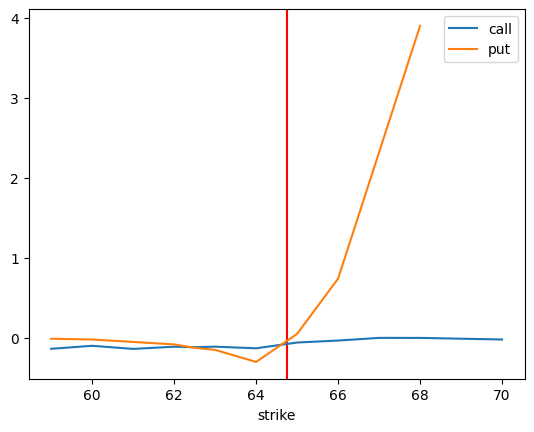

In [139]:
plot("KO")